## Titanic Survival Prediction Modelling

In [1]:
#import libraries
import os
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import keras
import tensorflow as tf

warnings.filterwarnings("ignore")

In [2]:
#check for the paths of the train, test and submission files
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
#read the train and test files using pandas read_csv
#train_titanic = pd.read_csv("/kaggle/input/titanic/train.csv")
#test_titanic = pd.read_csv("/kaggle/input/titanic/test.csv")

train_titanic = pd.read_csv("train.csv")
test_titanic = pd.read_csv("test.csv")

### **Data Exploration**

This section performs basic data exploration like number of columns, instances, null values. etc on both train and test datasets.

**Train data exploration**

Check few instances of train data

In [4]:
train_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_titanic.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


Check the information present in the data: columns, number of instances, null values, data type

In [6]:
train_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


This shows that the train dataset has 891 instances with 11 feature columns and 1 dependent column (Survived) and their data types. Features Age, Embarked and Cabin have missing values. 

In [7]:
#check for the null values in the dataset
train_titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

This shows Age and Cabin have a lot of null values compared to Embarked feature.

**Test data exploration**

Check few instances of test data

In [8]:
test_titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Check the information present in the test data: columns, number of instances, null values, data type

In [9]:
test_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


This shows that the test dataset has 481 instances with 11 feature columns and their data types. Here again features Age, Fare and Cabin have missing values.

In [10]:
#check for the null values in the dataset
test_titanic.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

This shows Age and Cabin have a lot of null values compared to Fare feature.

### Data Cleaning

This section performs data cleaning to fill the missing values in train and test data. This is done by first concatenating the train and test datasets, drop unnecessary columns, use Ordinal Encoder to encode the string values in columns: Sex, Title, Emabrked features and finally perform IterativeImputer to fill missing values.

In [11]:
#divide the train data into input features data: X and output dependent feature: y
X = train_titanic.drop(columns = "Survived", axis = 1)
y = train_titanic["Survived"]

#check for the shape of i/p and o/p data
print("X.shape:",X.shape)
print("y.shape:",y.shape)

X.shape: (891, 11)
y.shape: (891,)


In [12]:
#check few instances of input data
X.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [13]:
#check few instances of output data
y[:10]

0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64

In [14]:
len(y)

891

In [15]:
#concatenate train and test data into a single dataset: titanic
titanic = X.append(test_titanic, ignore_index = True)

Check if the concatenation was successful.

In [16]:
titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
titanic.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1304,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
1308,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [18]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


After the concatenation, the final dataset has 1309 entries, with 11 feature columns.

In [19]:
titanic.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

The dataset has missing values in columns: Age, Fare, Embarked and Cabin.

Create a below new features as follows:

1. "Family_Size" = This calculates the total number of people travelling aboard as a family. It is calculated as: Family_Size = Parch+SibSp+1

2. "Total_fare" = Total_fare is the fare paid per family to travel on the Titanic. The "Fare" column gives the individual fare values. Thus Total_fare is calculated as: Total_fare = Fare * Famliy_size

3. "Title" = This feature contains the prefixes used for a person's name. This is extracted from the "Name" column and is used for modelling, since from raw data visualization we have seen that Mrs, Miss, Royal have higher chance of survival compared to Mr, Officer.

In [20]:
#Family_size feature
titanic["Family_size"] = titanic["Parch"] + titanic["SibSp"] + 1

In [21]:
#Total_fare feature
titanic["Total_fare"] = titanic["Fare"] * titanic["Family_size"]

In [22]:
#Title feature
#extract the title from the Name using re
titanic["Title"] = list(map(lambda x: (re.search(r'[a-zA-Z]+\.',x).group()).capitalize(),titanic["Name"].values))

In [23]:
titanic["Title"].value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Ms.            2
Mlle.          2
Major.         2
Dona.          1
Lady.          1
Countess.      1
Jonkheer.      1
Sir.           1
Don.           1
Capt.          1
Mme.           1
Name: Title, dtype: int64

The Title column contains multiple title that seems similar. Thus we'll group and map some of the titles into common title.

In [24]:
titanic["Title"] = titanic["Title"].map({"Mr.":"Mr","Miss.":"Miss","Mrs.":"Mrs","Master.":"Master","Dr.":"Officer","Rev.":"Officer","Major.":"Officer","Col.":"Officer","Mlle.":"Miss","Mme.":"Miss","Jonkheer.":"Royal","Capt.":"Officer","Sir.":"Royal","Don.":"Royal","Ms.":"Miss","Lady.":"Royal","Countess.":"Royal"})

Check for the data if feature extraction of Family_size, Total_fare and Title was successful.

In [25]:
titanic.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Total_fare,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,14.5000,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,142.5666,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,7.9250,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,106.2000,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,8.0500,Mr


In [26]:
titanic.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size,Total_fare,Title
1304,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,1,8.0500,Mr
1305,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1,108.9000,NaN
1306,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,1,7.2500,Mr
1307,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,1,8.0500,Mr
1308,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,3,67.0749,Master


Drop unnecessary columns. 
1. PassengerID: Since this is only on ID column, this is not required for modelling and prediction
2. Name, Fare, SipSp, Parch: Since we extracted new features from these existing features, these columns are dropped too
3. Ticket: This contains the ticket number which again is not required for modelling and prediction
4. Cabin: This column contains the cabin in which passengers were travelling. This column has lot of missing values, about 70% of data is missing and filling this column is difficult with having only 30% of the data. Filling this column can result in false predictions and thus it is dropped.

In [27]:
titanic.drop(columns = ["PassengerId","Name","Ticket","Cabin","SibSp","Parch","Fare"], axis = 1, inplace = True)

Check for the final dataset used for data cleaning.

In [28]:
titanic.head()

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
0,3,male,22.0,S,2,14.5000,Mr
1,1,female,38.0,C,2,142.5666,Mrs
2,3,female,26.0,S,1,7.9250,Miss
3,1,female,35.0,S,2,106.2000,Mrs
4,3,male,35.0,S,1,8.0500,Mr


In [29]:
titanic.tail()

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
1304,3,male,NaN,S,1,8.0500,Mr
1305,1,female,39.0,C,1,108.9000,NaN
1306,3,male,38.5,S,1,7.2500,Mr
1307,3,male,NaN,S,1,8.0500,Mr
1308,3,male,NaN,C,3,67.0749,Master


In [30]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       1309 non-null   int64  
 1   Sex          1309 non-null   object 
 2   Age          1046 non-null   float64
 3   Embarked     1307 non-null   object 
 4   Family_size  1309 non-null   int64  
 5   Total_fare   1308 non-null   float64
 6   Title        1308 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 71.7+ KB


In [31]:
titanic[titanic["Embarked"].isnull()]

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
61,1,female,38.0,NaN,1,80.0,Miss
829,1,female,62.0,NaN,1,80.0,Mrs


Before performing data cleaning, the categorical features: embark, sex and title are converted to numerical values using OrdinalEncoder. The purpose of using OrdinalEncoder is to convert strings to intergers, and convert back the intergers to strings after data cleaning. This is done so that, one-hot encoding can be performed on the categorical features before modelling. Also, we convert the strings to intergers only for non-null values using OE keeping the null values as NaN.

In [32]:
#function to encode non-null cat. feature instances to integers 
def encode_data(data,encoder):
    #extract non-null values
    non_nulls = np.array(data.dropna())
    #convert to 2D for OE
    data_reshape = non_nulls.reshape(-1,1)
    #perform encoding
    data_encoded = encoder.fit_transform(data_reshape)
    #assign the intergers to non-null values and retain the null values
    data.loc[data.notnull()] = np.squeeze(data_encoded)
    return data

In [33]:
#instantiate OrdinalEncoder for each cat. feature
encoder_embark = OrdinalEncoder()
encoder_sex = OrdinalEncoder()
encoder_title = OrdinalEncoder()

#call the encode function
titanic["Embarked"] = encode_data(titanic["Embarked"],encoder_embark)
titanic["Sex"] = encode_data(titanic["Sex"],encoder_sex)
titanic["Title"] = encode_data(titanic["Title"],encoder_title)

Check if the encoding was successfull

In [34]:
titanic.head()

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
0,3,1.0,22.0,2,2,14.5000,2
1,1,0.0,38.0,0,2,142.5666,3
2,3,0.0,26.0,2,1,7.9250,1
3,1,0.0,35.0,2,2,106.2000,3
4,3,1.0,35.0,2,1,8.0500,2


In [35]:
titanic.tail()

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
1304,3,1.0,NaN,2,1,8.0500,2
1305,1,0.0,39.0,0,1,108.9000,NaN
1306,3,1.0,38.5,2,1,7.2500,2
1307,3,1.0,NaN,2,1,8.0500,2
1308,3,1.0,NaN,0,3,67.0749,0


This shows the encoding was done only for non-null values.

IterativeImputer: It is a method for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.

In [36]:
#perform IterativeImpution for impute the missing values
imputer = IterativeImputer(ExtraTreesRegressor())
encode_data = pd.DataFrame(np.round(imputer.fit_transform(titanic)),columns = titanic.columns)

Check for the data after imputation

In [37]:
encode_data.head()

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
0,3.0,1.0,22.0,2.0,2.0,14.0,2.0
1,1.0,0.0,38.0,0.0,2.0,143.0,3.0
2,3.0,0.0,26.0,2.0,1.0,8.0,1.0
3,1.0,0.0,35.0,2.0,2.0,106.0,3.0
4,3.0,1.0,35.0,2.0,1.0,8.0,2.0


In [38]:
encode_data.tail()

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
1304,3.0,1.0,30.0,2.0,1.0,8.0,2.0
1305,1.0,0.0,39.0,0.0,1.0,109.0,1.0
1306,3.0,1.0,38.0,2.0,1.0,7.0,2.0
1307,3.0,1.0,30.0,2.0,1.0,8.0,2.0
1308,3.0,1.0,8.0,0.0,3.0,67.0,0.0


In [39]:
encode_data.isnull().sum()

Pclass         0
Sex            0
Age            0
Embarked       0
Family_size    0
Total_fare     0
Title          0
dtype: int64

This shows the imputation was successfull and the data has no null values.

In [40]:
#function to convert the encoded intergers back to srtings
def inverse_encode(data,encoder):
    #convert to 2D for OE
    data_reshape  = data.values.reshape(-1,1)
    #perform inverse encoding
    data_inv_encoded = encoder.inverse_transform(data_reshape )
    #assign the strings to the initial non-null values
    data = np.squeeze(data_inv_encoded)
    return data

encode_data["Embarked"] = inverse_encode(encode_data["Embarked"],encoder_embark)
encode_data["Sex"] = inverse_encode(encode_data["Sex"],encoder_sex)
encode_data["Title"] = inverse_encode(encode_data["Title"],encoder_title)

Check if the inverse encoding is successful

In [41]:
encode_data.head()

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
0,3.0,male,22.0,S,2.0,14.0,Mr
1,1.0,female,38.0,C,2.0,143.0,Mrs
2,3.0,female,26.0,S,1.0,8.0,Miss
3,1.0,female,35.0,S,2.0,106.0,Mrs
4,3.0,male,35.0,S,1.0,8.0,Mr


In [42]:
encode_data.tail()

,Pclass,Sex,Age,Embarked,Family_size,Total_fare,Title
1304,3.0,male,30.0,S,1.0,8.0,Mr
1305,1.0,female,39.0,C,1.0,109.0,Miss
1306,3.0,male,38.0,S,1.0,7.0,Mr
1307,3.0,male,30.0,S,1.0,8.0,Mr
1308,3.0,male,8.0,C,3.0,67.0,Master


In [43]:
encode_data.iloc[829]

Pclass              1
Sex            female
Age                62
Embarked            C
Family_size         1
Total_fare         80
Title             Mrs
Name: 829, dtype: object

In [44]:
encode_data.isnull().sum()

Pclass         0
Sex            0
Age            0
Embarked       0
Family_size    0
Total_fare     0
Title          0
dtype: int64

**One-Hot encoding**

One-hot encode the categorical variables: sex, title and embark

In [45]:
#collect the categorical variables
cat_vab = encode_data.dtypes == object
cat_vab = encode_data.columns[cat_vab].tolist()

#the categorical features in the dataset
print("The categorical features are:",cat_vab)

The categorical features are: ['Sex', 'Embarked', 'Title']


In [46]:
num_vab = []

#iterate through the columns and append the num_vab list with numerical features
for fea in encode_data.columns:
    if fea not in cat_vab:
        num_vab.append(fea)

num_vab

['Pclass', 'Age', 'Family_size', 'Total_fare']

In [47]:
#create a data frame of categorical features after one hot encoding using pd.get_dummies()
cat_df = pd.get_dummies(encode_data[cat_vab])

#the dataframe for the categorical features after one hot encoding
print(cat_df.head(3))

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Title_Master  \
0           0         1           0           0           1             0   
1           1         0           1           0           0             0   
2           1         0           0           0           1             0   

   Title_Miss  Title_Mr  Title_Mrs  Title_Officer  Title_Royal  
0           0         1          0              0            0  
1           0         0          1              0            0  
2           1         0          0              0            0  


In [48]:
#the total number of features based on the values present in each categorical feature
print(cat_df.shape)

(1309, 11)


In [49]:
#create a dataframe of numerical features
num_df = encode_data[num_vab]

#the total number of numerical features 
print(num_df.shape)

(1309, 4)


In [50]:
#concat cat_df and num_df along the columns
data_df = pd.concat([num_df,cat_df], axis = 1)

#check data after concatenation
data_df.head()

,Pclass,Age,Family_size,Total_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
0,3.0,22.0,2.0,14.0,0,1,0,0,1,0,0,1,0,0,0
1,1.0,38.0,2.0,143.0,1,0,1,0,0,0,0,0,1,0,0
2,3.0,26.0,1.0,8.0,1,0,0,0,1,0,1,0,0,0,0
3,1.0,35.0,2.0,106.0,1,0,0,0,1,0,0,0,1,0,0
4,3.0,35.0,1.0,8.0,0,1,0,0,1,0,0,1,0,0,0


In [51]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         1309 non-null   float64
 1   Age            1309 non-null   float64
 2   Family_size    1309 non-null   float64
 3   Total_fare     1309 non-null   float64
 4   Sex_female     1309 non-null   uint8  
 5   Sex_male       1309 non-null   uint8  
 6   Embarked_C     1309 non-null   uint8  
 7   Embarked_Q     1309 non-null   uint8  
 8   Embarked_S     1309 non-null   uint8  
 9   Title_Master   1309 non-null   uint8  
 10  Title_Miss     1309 non-null   uint8  
 11  Title_Mr       1309 non-null   uint8  
 12  Title_Mrs      1309 non-null   uint8  
 13  Title_Officer  1309 non-null   uint8  
 14  Title_Royal    1309 non-null   uint8  
dtypes: float64(4), uint8(11)
memory usage: 55.1 KB


There are total 15 columns now with 1309 entires corresponding to 891 of training and 418 of testing data.

In [52]:
data_df.head()

,Pclass,Age,Family_size,Total_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
0,3.0,22.0,2.0,14.0,0,1,0,0,1,0,0,1,0,0,0
1,1.0,38.0,2.0,143.0,1,0,1,0,0,0,0,0,1,0,0
2,3.0,26.0,1.0,8.0,1,0,0,0,1,0,1,0,0,0,0
3,1.0,35.0,2.0,106.0,1,0,0,0,1,0,0,0,1,0,0
4,3.0,35.0,1.0,8.0,0,1,0,0,1,0,0,1,0,0,0


In [53]:
data_df.tail()

,Pclass,Age,Family_size,Total_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
1304,3.0,30.0,1.0,8.0,0,1,0,0,1,0,0,1,0,0,0
1305,1.0,39.0,1.0,109.0,1,0,1,0,0,0,1,0,0,0,0
1306,3.0,38.0,1.0,7.0,0,1,0,0,1,0,0,1,0,0,0
1307,3.0,30.0,1.0,8.0,0,1,0,0,1,0,0,1,0,0,0
1308,3.0,8.0,3.0,67.0,0,1,1,0,0,1,0,0,0,0,0


In [54]:
#divide the data into their respective train and test
train_data = data_df[:len(train_titanic)]
test_data = data_df[len(train_titanic):]
test_data = test_data.reset_index(drop = True)

In [55]:
test_data.head()

,Pclass,Age,Family_size,Total_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
0,3.0,34.0,1.0,8.0,0,1,0,1,0,0,0,1,0,0,0
1,3.0,47.0,2.0,14.0,1,0,0,0,1,0,0,0,1,0,0
2,2.0,62.0,1.0,10.0,0,1,0,1,0,0,0,1,0,0,0
3,3.0,27.0,1.0,9.0,0,1,0,0,1,0,0,1,0,0,0
4,3.0,22.0,3.0,37.0,1,0,0,0,1,0,0,0,1,0,0


In [56]:
#verify the shape of train and test data
print(train_data.shape)
print(test_data.shape)

(891, 15)
(418, 15)


In [57]:
#normalize the data
scale = StandardScaler()

#convert the output a dataframe
train_ = pd.DataFrame(scale.fit_transform(train_data), columns = train_data.columns)
test_ = pd.DataFrame(scale.transform(test_data), columns = test_data.columns)

#check the scaled data
train_.head(3)

,Pclass,Age,Family_size,Total_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
0,0.827377,-0.548403,0.059160,-0.390162,-0.737695,0.737695,-0.485576,-0.307562,0.619306,-0.216803,-0.513644,0.850532,-0.403962,-0.143592,-0.075122
1,-1.566107,0.612921,0.059160,0.387247,1.355574,-1.355574,2.059412,-0.307562,-1.614710,-0.216803,-0.513644,-1.175735,2.475480,-0.143592,-0.075122
2,0.827377,-0.258072,-0.560975,-0.426321,1.355574,-1.355574,-0.485576,-0.307562,0.619306,-0.216803,1.946875,-1.175735,-0.403962,-0.143592,-0.075122


In [58]:
test_.head(3)

,Pclass,Age,Family_size,Total_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
0,0.827377,0.322590,-0.560975,-0.426321,-0.737695,0.737695,-0.485576,3.251373,-1.614710,-0.216803,-0.513644,0.850532,-0.403962,-0.143592,-0.075122
1,0.827377,1.266166,0.059160,-0.390162,1.355574,-1.355574,-0.485576,-0.307562,0.619306,-0.216803,-0.513644,-1.175735,2.475480,-0.143592,-0.075122
2,-0.369365,2.354908,-0.560975,-0.414268,-0.737695,0.737695,-0.485576,3.251373,-1.614710,-0.216803,-0.513644,0.850532,-0.403962,-0.143592,-0.075122


**Split data into train and validation sets**

In [59]:
X_train,X_val,y_train,y_val = train_test_split(train_, y, test_size = 0.1, random_state = 9)

#check the shape of each split
print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_val: ",X_val.shape)
print("y_val: ",y_val.shape)

X_train:  (801, 15)
y_train:  (801,)
X_val:  (90, 15)
y_val:  (90,)


In [60]:
X_train.head(3)

,Pclass,Age,Family_size,Total_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royal
494,0.827377,-0.620986,-0.560975,-0.426321,-0.737695,0.737695,-0.485576,-0.307562,0.619306,-0.216803,-0.513644,0.850532,-0.403962,-0.143592,-0.075122
615,-0.369365,-0.403238,1.299429,1.092339,1.355574,-1.355574,-0.485576,-0.307562,0.619306,-0.216803,1.946875,-1.175735,-0.403962,-0.143592,-0.075122
882,0.827377,-0.548403,-0.560975,-0.408242,1.355574,-1.355574,-0.485576,-0.307562,0.619306,-0.216803,1.946875,-1.175735,-0.403962,-0.143592,-0.075122


### Modelling

### 1. Neural Network from scratch

In [61]:
#import the NN class
from neural_network_model import Layer, NeuralNetwork

In [62]:
#get the values and reshape to array type required by the model
X_train1 = X_train.values
y_train1 = y_train.values
y_train1 = y_train1.reshape(-1,1)

In [63]:
#clear session
keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(52)

nn = NeuralNetwork()
nn.add_layer(Layer(15, 8, 'relu'))
nn.add_layer(Layer(8, 4, 'relu'))
nn.add_layer(Layer(4, 1, 'sigmoid'))

#train the neural network
model_loss = nn.train(X_train1, y_train1, 0.003, 800)

Epoch: 0, loss: 0.60452, Training accuracy:0.38327
Epoch: 10, loss: 0.33915, Training accuracy:0.38327
Epoch: 20, loss: 0.17932, Training accuracy:0.80649
Epoch: 30, loss: 0.15262, Training accuracy:0.80275
Epoch: 40, loss: 0.14276, Training accuracy:0.81149
Epoch: 50, loss: 0.13617, Training accuracy:0.82272
Epoch: 60, loss: 0.13225, Training accuracy:0.83645
Epoch: 70, loss: 0.12986, Training accuracy:0.83645
Epoch: 80, loss: 0.12827, Training accuracy:0.83521
Epoch: 90, loss: 0.12709, Training accuracy:0.83396
Epoch: 100, loss: 0.12609, Training accuracy:0.83396
Epoch: 110, loss: 0.12520, Training accuracy:0.83396
Epoch: 120, loss: 0.12438, Training accuracy:0.83645
Epoch: 130, loss: 0.12374, Training accuracy:0.8377
Epoch: 140, loss: 0.12320, Training accuracy:0.83895
Epoch: 150, loss: 0.12272, Training accuracy:0.8402
Epoch: 160, loss: 0.12231, Training accuracy:0.83645
Epoch: 170, loss: 0.12196, Training accuracy:0.83645
Epoch: 180, loss: 0.12163, Training accuracy:0.83645
Epoch:

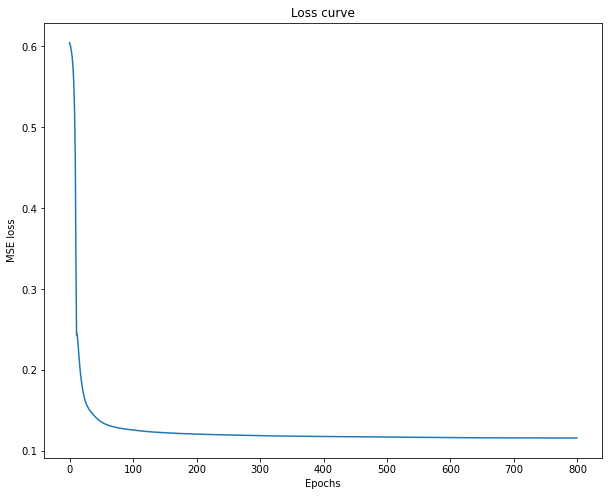

In [64]:
#plot the training loss curve
plt.figure(figsize = (10,8))
plt.plot(model_loss)
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

In [65]:
#evaluate on validation data
nn_pred = nn.predict(X_val.values)
acc_score = accuracy_score(nn_pred, y_val.values.flatten())
print("Accuracy: {:.2%}".format(acc_score))

Accuracy: 84.44%


In [66]:
#predict on test data
nn_test_pred = nn.predict(test_.values)

In [67]:
#nn_sub_file = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
nn_sub_file = pd.read_csv("gender_submission.csv")
nn_sub_file.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [68]:
nn_sub_file["Survived"] = nn_test_pred
nn_sub_file.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [69]:
nn_sub_file.to_csv("NN_scratch_submission_file.csv",index = False)

**Neural Network with Early Stopping**

In [70]:
#clear the session
keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(19)

nn = NeuralNetwork()
nn.add_layer(Layer(15, 32, 'tanh'))
nn.add_layer(Layer(32, 16, 'tanh'))
nn.add_layer(Layer(16, 8, 'tanh'))
nn.add_layer(Layer(8, 4, 'relu'))
nn.add_layer(Layer(4, 1, 'sigmoid'))

#train the neural network
nnet_loss = nn.train(X_train1, y_train1, 0.3, 800, early_stopping = True)

Epoch: 0, loss: 0.59561, Training accuracy:0.38327
Epoch: 10, loss: 0.30975, Training accuracy:0.38327
Epoch: 20, loss: 0.30974, Training accuracy:0.38327
Epoch: 30, loss: 0.30969, Training accuracy:0.38327
Epoch: 40, loss: 0.17887, Training accuracy:0.75281
Epoch: 50, loss: 0.17896, Training accuracy:0.75281
Epoch: 60, loss: 0.17863, Training accuracy:0.75281
Epoch: 70, loss: 0.17495, Training accuracy:0.76155
Epoch: 80, loss: 0.17403, Training accuracy:0.76779
Epoch: 90, loss: 0.17395, Training accuracy:0.76779
Epoch: 100, loss: 0.17368, Training accuracy:0.76779
Epoch: 110, loss: 0.17415, Training accuracy:0.76779
Epoch: 120, loss: 0.17519, Training accuracy:0.76779
Epoch: 130, loss: 0.17379, Training accuracy:0.76779
Epoch: 140, loss: 0.17369, Training accuracy:0.76779
Epoch: 150, loss: 0.17379, Training accuracy:0.76779
Epoch: 160, loss: 0.17388, Training accuracy:0.76779
Epoch: 170, loss: 0.17418, Training accuracy:0.76779
Epoch: 180, loss: 0.17684, Training accuracy:0.76779
Earl

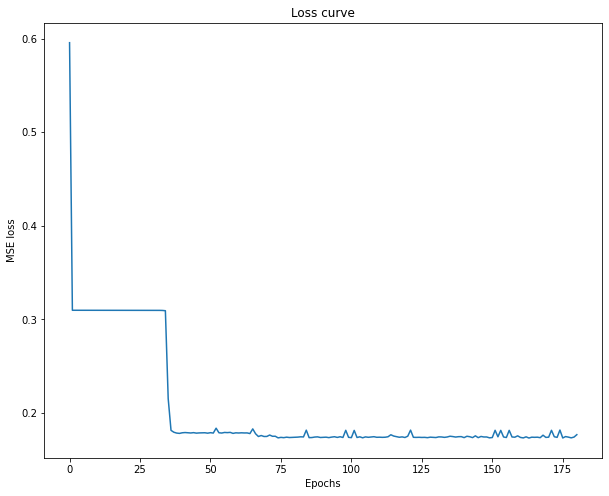

In [71]:
#plot the training loss curve
plt.figure(figsize = (10,8))
plt.plot(nnet_loss)
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.show()

In [72]:
#evaluate on validation data
nnet_pred = nn.predict(X_val.values)
accu_score = accuracy_score(nnet_pred, y_val.values.flatten())
print("Accuracy: {:.2%}".format(accu_score))

Accuracy: 78.89%


In [73]:
#predict on test data
nnet_test_pred = nn.predict(test_.values)

In [74]:
#nn_sub_file1 = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
nn_sub_file1 = pd.read_csv("gender_submission.csv")
nn_sub_file1["Survived"] = nnet_test_pred
nn_sub_file1.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [75]:
nn_sub_file1.to_csv("nn_submission_file2.csv",index = False)

### 2. Ensemble Voting Classifier model

In [76]:
#individual classifiers for voting classifier
#Logistic Regression
lr = LogisticRegression(class_weight = 'balanced')

#Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators = 200,learning_rate = 0.01, criterion = 'mse',
                                 max_depth = 6,min_samples_leaf = 2,random_state = 16)

#MLP classifier
mlp = MLPClassifier(learning_rate = "constant",learning_rate_init = 0.001,random_state = 1, max_iter = 500)

#Voting classifier of the above models
vc = VotingClassifier(estimators=[('lr', lr), ('gbc', gbc), ('mlp', mlp)], voting = 'hard')
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced')),
                             ('gbc',
                              GradientBoostingClassifier(criterion='mse',
                                                         learning_rate=0.01,
                                                         max_depth=6,
                                                         min_samples_leaf=2,
                                                         n_estimators=200,
                                                         random_state=16)),
                             ('mlp',
                              MLPClassifier(max_iter=500, random_state=1))])

In [77]:
#predict on validation data
vc_pred = vc.predict(X_val)
vc_acc = accuracy_score(y_val,vc_pred)
print("Accuracy: {:.2%}".format(vc_acc))

#predict on test data
vc_test_pred = vc.predict(test_)

Accuracy: 87.78%


In [78]:
#voting_sub_file = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
voting_sub_file = pd.read_csv("gender_submission.csv")
voting_sub_file["Survived"] = vc_test_pred
voting_sub_file.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [79]:
voting_sub_file.to_csv("voting_classifier_SubFile.csv",index = False)

### Average and Weighted Average Ensemble Model

**Logistic Regression**

In [80]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [81]:
lr_pred = lr.predict(X_val)
lr_acc = accuracy_score(y_val,lr_pred)
print("Accuracy: {:.2%}".format(lr_acc))

lr_test_pred = lr.predict(test_)

Accuracy: 81.11%


**Gradient Boosting Classifier**

In [82]:
gbc = GradientBoostingClassifier(n_estimators = 200,learning_rate = 0.1, criterion = 'mse',
                                 max_depth = 6,min_samples_leaf = 2,random_state = 16)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(criterion='mse', max_depth=6, min_samples_leaf=2,
                           n_estimators=200, random_state=16)

In [83]:
gbc_pred = gbc.predict(X_val)
gbc_acc = accuracy_score(y_val,gbc_pred)
print("Accuracy: {:.2%}".format(gbc_acc))

gbc_test_pred = gbc.predict(test_)

Accuracy: 81.11%


**MLP Classifier**

In [84]:
mlp = MLPClassifier(max_iter = 300)
mlp.fit(X_train,y_train)

MLPClassifier(max_iter=300)

In [85]:
mlp_pred = mlp.predict(X_val)
mlp_acc = accuracy_score(y_val,mlp_pred)
print("Accuracy: {:.2%}".format(mlp_acc))

mlp_test_pred = mlp.predict(test_)

Accuracy: 82.22%


In [86]:
#lr_sub_file = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
lr_sub_file = pd.read_csv("gender_submission.csv")
lr_sub_file["Survived"] = lr_test_pred
lr_sub_file.to_csv("lr.csv",index = False)

#gbc_sub_file = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
gbc_sub_file = pd.read_csv("gender_submission.csv")
gbc_sub_file["Survived"] = gbc_test_pred
gbc_sub_file.to_csv("gbc.csv",index = False)

#mlp_sub_file = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
mlp_sub_file = pd.read_csv("gender_submission.csv")
mlp_sub_file["Survived"] = mlp_test_pred
mlp_sub_file.to_csv("mlp.csv",index = False)

### 3.Average Ensemble model

In [87]:
nn_pred = np.array(nn_pred)
nn_test_pred = np.array(nn_test_pred)

In [88]:
#validation data prediction
average_pred = (lr_pred.reshape(-1,1) + gbc_pred.reshape(-1,1) + nn_pred.reshape(-1,1) + 
                mlp_pred.reshape(-1,1))/4

#thresholding
avg_pred = (average_pred >= 0.5).astype(int)
avg_acc = accuracy_score(y_val,avg_pred)
print("Validation Accuracy: {:.2%}".format(avg_acc))

Validation Accuracy: 82.22%


In [89]:
#test data
average_test_pred = (lr_test_pred.reshape(-1,1) + gbc_test_pred.reshape(-1,1) + nn_test_pred.reshape(-1,1) + 
                    mlp_test_pred.reshape(-1,1))/4

#test data thresholding
avg_test_pred = (average_test_pred >= 0.5).astype(int)

In [90]:
#avg_sub_file = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
avg_sub_file = pd.read_csv("gender_submission.csv")
avg_sub_file["Survived"] = avg_test_pred
avg_sub_file.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [91]:
avg_sub_file.to_csv("avg_ensemble_SubFile.csv",index = False)

### 4. Weighted Average Ensemble Model

In [92]:
#validation data
wa_pred = (0.2 * gbc_pred.reshape(-1,1) + 0.4 * nn_pred.reshape(-1,1)  + 0.4 * mlp_pred.reshape(-1,1))

#thresholding data
wt_avg_pred = (wa_pred >= 0.5).astype(int)
wa_acc = accuracy_score(y_val,wt_avg_pred)
print("Accuracy: {:.2%}".format(wa_acc))

Accuracy: 85.56%


In [93]:
#test data
wavg_test_pred = (0.2 * gbc_test_pred.reshape(-1,1) + 0.4 * nn_test_pred.reshape(-1,1)  + 0.4 * mlp_test_pred.reshape(-1,1))


#test data thresholding
wa_test_pred = (wavg_test_pred >= 0.5).astype(int)

In [94]:
#wa_sub_file = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
wa_sub_file = pd.read_csv("gender_submission.csv")
wa_sub_file["Survived"] = wa_test_pred
wa_sub_file.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [95]:
wa_sub_file.to_csv("WtdAvg_ensemble_SubFile.csv",index = False)

The above modelling and results show that the NN model from scratch with 1 hidden layer has a validation accuracy of 84.4%, Voting Classifier has validation accuracy of 87.7% while the average has 82.2% and weighted average has 85.5%.